In [35]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:

import pandas as pd
data_path = "/content/drive/MyDrive/repo/cleaned_nfl.csv"
df= pd.read_csv(data_path)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        11231 non-null  object 
 1   schedule_season      11231 non-null  int64  
 2   schedule_week        11231 non-null  object 
 3   schedule_playoff     11231 non-null  bool   
 4   team_home            11231 non-null  object 
 5   score_home           11231 non-null  float64
 6   score_away           11231 non-null  float64
 7   team_away            11231 non-null  object 
 8   team_favorite_id     11231 non-null  object 
 9   spread_favorite      11231 non-null  float64
 10  over_under_line      11231 non-null  object 
 11  stadium              11231 non-null  object 
 12  stadium_neutral      11231 non-null  bool   
 13  weather_temperature  11231 non-null  float64
 14  weather_wind_mph     11231 non-null  float64
 15  weather_humidity     11231 non-null 

In [37]:
df['schedule_date'] = pd.to_datetime(df['schedule_date'], errors='coerce')

# Add new columns
df['schedule_year'] = df['schedule_date'].dt.year
df['schedule_month'] = df['schedule_date'].dt.month
df['schedule_day_week'] = df['schedule_date'].dt.weekday + 1  # Day of the week name
df['schedule_day_month'] = df['schedule_date'].dt.day



# Attempt to convert over_under_line to float, coercing errors to NaN
df['over_under_line'] = pd.to_numeric(df['over_under_line'], errors='coerce')
df['over_under_line'] = df['over_under_line'].astype(float)

df['team_home_is_fav'] = (df['team_favorite_name'] == df['team_home']).astype(int)

df = df.drop(columns=['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff', 'team_favorite_id', 'stadium_neutral' , 'team_favorite_name'] )

df = df.dropna()


df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 11169 entries, 0 to 11230
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team_home            11169 non-null  object 
 1   score_home           11169 non-null  float64
 2   score_away           11169 non-null  float64
 3   team_away            11169 non-null  object 
 4   spread_favorite      11169 non-null  float64
 5   over_under_line      11169 non-null  float64
 6   stadium              11169 non-null  object 
 7   weather_temperature  11169 non-null  float64
 8   weather_wind_mph     11169 non-null  float64
 9   weather_humidity     11169 non-null  float64
 10  schedule_year        11169 non-null  int32  
 11  schedule_month       11169 non-null  int32  
 12  schedule_day_week    11169 non-null  int32  
 13  schedule_day_month   11169 non-null  int32  
 14  team_home_is_fav     11169 non-null  int64  
dtypes: float64(7), int32(4), int64(1), object

In [38]:
# Verify the remaining columns
df.head()

,team_home,score_home,score_away,team_away,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph,weather_humidity,schedule_year,schedule_month,schedule_day_week,schedule_day_month,team_home_is_fav
0,Green Bay Packers,33.0,14.0,Oakland Raiders,-13.5,43.0,Orange Bowl,60.0,12.0,74.0,1968,1,7,14,1
1,Baltimore Colts,7.0,16.0,New York Jets,-18.0,40.0,Orange Bowl,66.0,12.0,80.0,1969,1,7,12,1
2,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,-12.0,39.0,Tulane Stadium,55.0,14.0,84.0,1970,1,7,11,0
3,Baltimore Colts,16.0,13.0,Dallas Cowboys,-2.5,36.0,Orange Bowl,59.0,11.0,60.0,1971,1,7,17,1
4,Dallas Cowboys,24.0,3.0,Miami Dolphins,-6.0,34.0,Tulane Stadium,34.0,18.0,40.0,1972,1,7,16,1


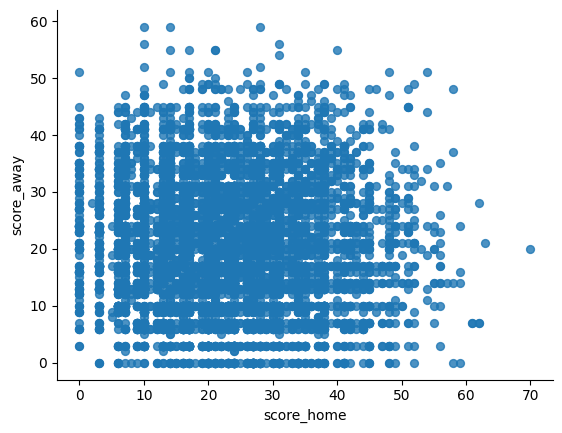

In [39]:
# @title score_home vs score_away

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='score_home', y='score_away', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
# Assuming df is already loaded with the columns as shown above

# One-hot encode categorical columns
categorical_cols = ['team_home', 'team_away', 'stadium']
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])

# Normalize numerical columns
numerical_cols = ['spread_favorite', 'over_under_line', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_year', 'schedule_month', 'schedule_day_week', 'schedule_day_month' , 'team_home_is_fav']
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(df[numerical_cols])

# Combine processed features
X = np.hstack([encoded_cats, scaled_nums])
y = df[['score_home', 'score_away']].values

print(X.shape)
print(y.shape)


(11169, 199)
(11169, 2)


In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2)  # Output layer for score_home and score_away
])

model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.2f}")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 318.8860 - val_loss: 97.4957
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 103.7407 - val_loss: 93.6872
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 99.8489 - val_loss: 93.1065
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 97.8750 - val_loss: 93.0928
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 96.0975 - val_loss: 94.2225
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 94.3334 - val_loss: 93.4002
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 96.0842 - val_loss: 92.2821
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 91.6283 - val_loss: 92.6990
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 91.9619 - val_loss: 93.1196
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 90.7742 - val_loss: 93.0967
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 89.5496 - val_loss: 94.4778
Epoch 12/100
224/224 ━━━━━━━